In [8]:
import numpy as np
from types import SimpleNamespace
from scipy import optimize
from matplotlib import pyplot as plt


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [9]:
# define parameter namespace
par = SimpleNamespace()
par.eta = 0.5
par.w = 1.0

kappa = [1.0, 2.0]

# profit function as defined in assignment text
def profits(par, ell, kappa):
    return kappa*ell**(1-par.eta)-par.w*ell

# optimal ell based on analytical solution
def ell_opt_anal(par, kappa):
    """
    Calculates the optimal value of ell based on the analytical solution.

    Parameters:
    - par: Parameter namspace containing model parameters.
    - kappa: Array of kappa values.

    Returns:
    - ell_opt: Array of optimal ell values corresponding to each kappa value.
    """
    ell_opt = [None]*len(kappa)
    for i, k in enumerate(kappa):
        ell_opt[i] = ((1-par.eta)*k/par.w)**(1/par.eta)
    return ell_opt

# rule els based on rule for question 2.2 sames as analytical, but non list based inputs
def ell_opt_rulebased(par, kappa):
    """
    Calculates the optimal value of ell based on a rule-based formula.
    Parameters:
    - par: Parameter namespace containing model parameters.
    - kappa: kappa value.

    Returns:
    - ell_opt: optimal ell value corresponding to kappa value.
    """
    return ((1-par.eta)*kappa/par.w)**(1/par.eta)

# optimal ell 
def sol_ell(par, kappa):
    """ 
    Calculates optimal ell numerically for a list of given kappas
    Parameters:
    - par: simple namesspacem with model parameters 
    - kappa: array of kappas

    Returns
    - res: Array of results from optimization
    """
    res = [None] * len(kappa)
    #loop through kappas
    for i, k in enumerate(kappa):
        #define objective function 
        obj = lambda ell: -profits(par, ell, k)
        # call optimizer from scipy
        x0 = [0.1]
        res[i] = optimize.minimize(obj, x0, method='nelder-mead', bounds=((0, np.inf), ))
    return res

res = sol_ell(par, kappa)
opt_anal = ell_opt_anal(par, kappa)


In [10]:
print(res[0].x, res[1].x,opt_anal)

[0.25] [1.] [0.25, 1.0]


Optimizing numerically we find the same solution as the analytical solution. We can check this further by using the numpy "isclose" function, using this we again find that the numerical and analytical solution is the same:

In [11]:
print(np.isclose(res[0].x,opt_anal[0]),
np.isclose(res[1].x, opt_anal[1]))

[ True] [ True]


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [12]:
# deffine new parameters
par.rho = 0.90
par.iota = 0.01
par.sigma = 0.1
par.R = (1+0.01)**(1/12)
par.K = 500
par.kappa_init = 1
par.T = 120
par.Delta = 0


def kappa_series(par):
    """
    Calculates AR(1) series for given parameters
    Parameters:
    - par: simple namespace with model paramets
    Returns: 
    - kappa_ar1: AR(1) timeseries of kappa
    """

    eps = np.random.normal(loc=-0.5*par.sigma**2,scale=par.sigma, size=par.T) #create T shocks
    log_kappa_ar1 = np.zeros(par.T) #intitiate list for log kappas
    kappa_ar1 = np.zeros(par.T) # initiate list kappas 
    log_kappa_ar1[0] = par.rho*np.log(par.kappa_init)+eps[0] #log kappa0
    kappa_ar1[0] = np.exp(log_kappa_ar1[0]) #kappa 0
    for i in range(par.T):
        if i > 0: #calculate log kappa and kappa for period t
            log_kappa_ar1[i] = par.rho*np.log(kappa_ar1[i-1]) + eps[i]
            kappa_ar1[i] = np.exp(log_kappa_ar1[i])
        else: #let kappa0 be kappa0 
            kappa_ar1[i] = kappa_ar1[i]
            log_kappa_ar1[i] = log_kappa_ar1[i]
    return kappa_ar1

In [13]:
def h_func(par, shocks):
    """
    Calculates discounted profits for par.T periods, for given shocks
    Args:
    - par: SimpleNamespace with model parameters
    - shocks: AR(1) process of shocks

    Returns:
    - np.sum(profit_series): sum of discounted shocks.
    """

    profit_series = np.zeros(par.T)    
    ell_series = ell_opt_rulebased(par, shocks)

    for i in range(par.T):
        if i > 0 and np.abs(ell_series[i]-ell_series[i-1]) > par.Delta:
            profit_series[i] = (par.R**-i)*(profits(par, ell_series[i], shocks[i]) -par.iota)
        elif i > 0 and np.abs(ell_series[i]-ell_series[i-1]) <= par.Delta:
            ell_series[i] = ell_series[i-1] # in this case set ell_t to ell_t-1
            profit_series[i] = (par.R**-i)*profits(par, ell_series[i], shocks[i])
    return np.sum(profit_series)


def big_H(par):
    """
    Simulates profits par.K times
    Args:
    - par: SimpleNamespace with model parameters

    Returns:
    - np.mean(h_list): mean of simulated profits
    """
    h_list = np.zeros(par.K)
    for i in range(par.K):
        shocks = kappa_series(par)
        h_list[i] = h_func(par, shocks)
    return np.mean(h_list)

With above functions we can calculate the expected value of future profits. we plot the results for different Ks to check if K affects the result much. We choose to go with k=1000 for the rest of the assignment.

Text(0, 0.5, 'Expected profits')

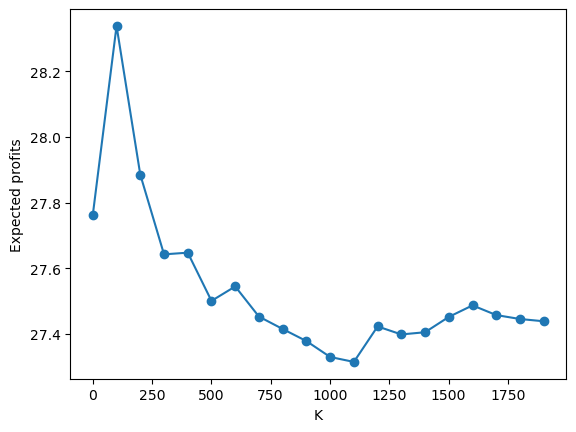

In [15]:
par.Delta = 0
# par.iota = 0.01 # consider adding
Ks = np.arange(1, 2000, step=100)

prof_Delta_0 = np.zeros(len(Ks))

for i,K in enumerate(Ks):
    par.K = K
    np.random.seed(1234)
    prof_Delta_0[i] = big_H(par)

fig, ax = plt.subplots(1,1)
ax.plot(Ks, prof_Delta_0, marker='o')
ax.set_xlabel('K')
ax.set_ylabel('Expected profits')

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [18]:
# write your code here
par.Delta= 0.05
par.K = 1000
np.random.seed(1234)
profits_high_Delta = big_H(par)
print(f"Profits for high delta {profits_high_Delta:.3f},\n Profits delta =0 {prof_Delta_0[10]:.3f}")

Profits for high delta 28.004,
 Profits delta =0 27.330


We see that profitability is improved for a higher $\Delta$

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [19]:
# write your code here
par.K = 1000
def obj(Delta, par):
    """
    Objective function used for optimizing choice Delta
    Returns:
    - negative of expected profits function
    """
    np.random.seed(1234)
    par.Delta = Delta
    return -1*big_H(par)
def sol_Delta(par):
    """
    Calculates optimal Delta
    Parameters:
    - par: SimpleNamespace with model parameters 
    """
    x0 = [0.01]
    res = optimize.minimize(obj, args=(par), x0=x0, method='nelder-mead')
    return res

In [20]:
optimalDelta = sol_Delta(par)

In [25]:
print(f"The optimal solution is {optimalDelta.x[0]:.3f}")

The optimal solution is 0.075


We can illustrate this in a plot with delta on the x axis an profits on the y-axis. The code takes a little long to run.

In [22]:
from tqdm import tqdm 
par.K = 1000
H = np.empty(100)
Delta = np.linspace(0,0.5,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    np.random.seed(1234)
    H[i] = big_H(par)

100it [01:42,  1.02s/it]


Text(0, 0.5, 'Expected profits')

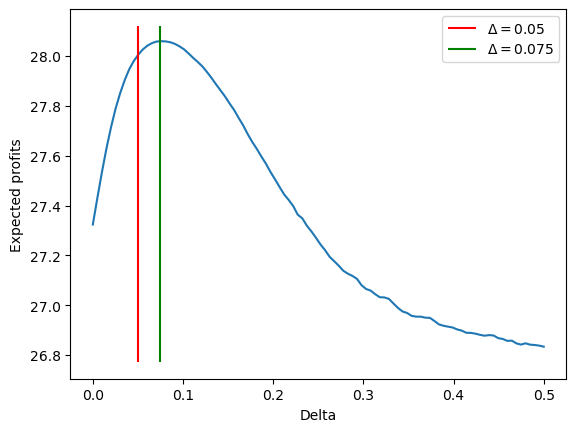

In [24]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ymin = ax.get_ylim()[0]
ymax = ax.get_ylim()[1]
# Add a vertical line at x=3 aligned with the top and bottom of the figure
ax.vlines(x=0.05, ymin=ymin, ymax=ymax, color='r', label="$\Delta = 0.05$")
ax.vlines(x=0.075, ymin=ymin, ymax=ymax, color='g', label="$\Delta = 0.075$")
ax.legend()
ax.set_xlabel('Delta')
ax.set_ylabel('Expected profits')


Here it we can see that there is an obvious peak around $\Delta=0.075$


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



**Question 5**: ANSWER: negative shocks has an implementing cost that is twice as big?

In [83]:
def h_func_new(par, shocks):
    """
    Calculates discounted profits for par.T periods, for given shocks
    Args:
    - par: SimpleNamespace with model parameters
    - shocks: AR(1) process of shocks

    Returns:
    - np.sum(profit_series): sum of discounted shocks.
    """

    profit_series = np.zeros(par.T)    
    ell_series = ell_opt_rulebased(par, shocks)

    for i in range(par.T):
        if i > 0 and ell_series[i-1]-ell_series[i] > par.Delta: # bad shock
            profit_series[i] = (par.R**-i)*(profits(par, ell_series[i], shocks[i]) - 2*par.iota)
        elif  i > 0 and ell_series[i-1]-ell_series[i] < 0: # good shock 
            profit_series[i] = (par.R**-i)*(profits(par, ell_series[i], shocks[i]) -par.iota)
        else:
            ell_series[i] = ell_series[i-1] # in this case set ell_t to ell_t-1
            profit_series[i] = (par.R**-i)*profits(par, ell_series[i], shocks[i])
    return np.sum(profit_series)


def big_H_new(par):
    """
    Simulates profits par.K times
    Args:
    - par: SimpleNamespace with model parameters

    Returns:
    - np.mean(h_list): mean of simulated profits
    """
    h_list = np.zeros(par.K)
    for i in range(par.K):
        shocks = kappa_series(par)
        h_list[i] = h_func_new(par, shocks)
    return np.mean(h_list)

In [84]:
par.K = 1000
def obj_new(Delta, par):
    """
    Objective function used for optimizing choice Delta
    Returns:
    - negative of expected profits function
    """
    np.random.seed(1234)
    par.Delta = Delta
    return -1*big_H_new(par)
def sol_Delta_new(par):
    """
    Calculates optimal Delta
    Parameters:
    - par: SimpleNamespace with model parameters 
    """
    x0 = [0.1]
    res = optimize.minimize(obj_new, args=(par), x0=x0, method='nelder-mead')
    return res

In [85]:
par.K = 200
par.dont_fire = 2
optimalDelta = sol_Delta_new(par)
print(f"The optimal solution is {optimalDelta.x[0]:.3f}")

1.0018667352504245
1.020425353387226
1.0517187357587654
0.9069197808941731
0.9596882704799904
1.0654457741204058
0.9493749022746925
0.8852681953634699
0.8590873072094695
1.0593509667194176
1.118077079957871
0.9288278381421099
1.0887228918299905
1.0179096747082186
0.9197206403133339
1.0277705231875058
1.044464976142459
0.9721391092905918
0.991576021224445
1.1028744305568883
1.208253474580239
0.8844666229169094
1.0146033983986666
0.9540306187691541
1.0782048074628698
0.9744535675252363
0.987944922502568
0.9973771452497305
0.8078938312033804
1.0373191929102403
1.035146002835651
0.9269233840156369
0.8798337610825828
1.0048524282676954
0.9232054835574371
1.1547270364135112
0.968708262625618
1.0118895200265248
1.0751538886818885
0.9638693504668637
0.9220799657624563
1.1435094003550248
1.1619658661235275
0.8207360795599359
0.8759814722118187
1.069663392979184
0.925100937158998
1.1600291392785258
0.8035532546133732
1.09139747963691
1.0078042806280378
1.0942007958193931
0.9130935732508262
0.892

In [81]:
from tqdm import tqdm 
par.K = 100
H = np.empty(100)
Delta = np.linspace(0,0.5,100)
for i, d in tqdm(enumerate(Delta)):
    par.Delta = d
    np.random.seed(1234)
    H[i] = big_H_new(par)

100it [00:08, 12.30it/s]


Text(0, 0.5, 'Expected profits')

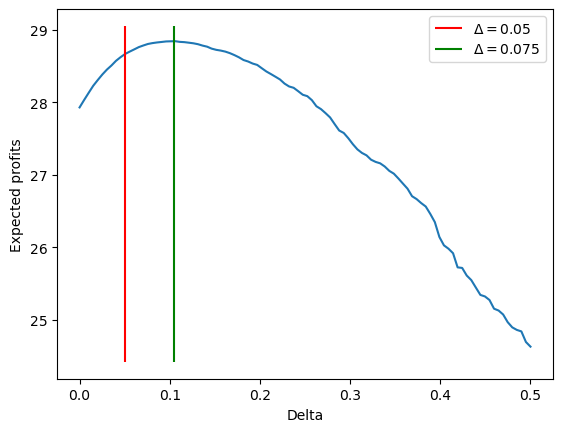

In [103]:
fig, ax = plt.subplots(1,1)
ax.plot(Delta, H)
ymin = ax.get_ylim()[0]
ymax = ax.get_ylim()[1]
# Add a vertical line at x=3 aligned with the top and bottom of the figure
ax.vlines(x=0.05, ymin=ymin, ymax=ymax, color='r', label="$\Delta = 0.05$")
ax.vlines(x=0.105, ymin=ymin, ymax=ymax, color='g', label="$\Delta = 0.075$")
ax.legend()
ax.set_xlabel('Delta')
ax.set_ylabel('Expected profits')


In [104]:
a, b = 2

print(a,b)

TypeError: cannot unpack non-iterable int object

**Question 5:** ANSWER: possibility to hire worker for rest of periods (cant fire) but lower wage. Long-term contracts effect of .

In [101]:
def profits_new(ells, par, kappa):
    return kappa*(ells[0]+ells[1])**(1-par.eta)-(par.w*ells[0]+par.w_low*ells[1]) #ells1 = low

par.w_low = 0.9

#define objective function 
obj_new = lambda ells: -profits_new(ells, par, 1)
# call optimizer from scipy
x0 = np.array([1,1])
opt = optimize.minimize(obj_new, x0, method='nelder-mead', bounds=((0, np.inf), (0,np.inf)))


In [102]:
opt.x

array([0.        , 0.30863227])